<h1> Classification Analysis On Game Of Thrones Dataset </h1>
    
<h2> Purpose of Code </h2>

This code utilizes the data set Game of Thrones to build a model that determines if a character is alive or not.
    
 Errors/Bugs identified. None.
    
<h2> Preparation and exploration of the data </h2>

All necessary <strong>packages</strong> , <strong>dictionary</strong>  have been loaded as well as some of the <strong>user defined functions</strong>.

<h3> Packages </h3>

In [26]:
# importing libraries
import numpy            as np
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
import gender_guesser.detector as gender             # installing gender_guesser
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree                   # tree plots
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer

# loading data
got_dataset = pd.read_excel('./GOT_character_predictions.xlsx')


# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

<h3> User Defined Functions </h3>

In [27]:
#User Defined Fuctions

#########################
# missing value flagger 
########################

def mv_flagger(df):
    for col in df:
        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df

########################################
# optimal_neighbors
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
x_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the x data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing x_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()
    
###########################
#text_split_feature
###########################

def text_split_feature(col, df, sep=' ', new_col_name='number_of_names'):
    
    df[new_col_name] = 0
    
    for index, val in df.iterrows():
        df.loc[index,new_col_name] = len(df.loc[index,col].split(sep = ' '))

<h3> Dictionary </h3>

Load the GOT dictionary inorder to asses the meaning of all the variables and determine how to engineer them.

In [28]:
# pulling up data dictionary
#got_description = pd.read_excel('./GOT_data_dictionary.xlsx')

# displaying the data dictionary
#got_description

<h2> Feature Engineering </h2>

This next code is meant to help us clean out data by <strong>flagging missing values</strong>, <strong>dropping columns</strong>, <strong>imputing missing values and rows</strong>, <strong>creating new columns</strong> and finally <strong>creating dummie variables</strong>.

In [29]:
# changing all column names to lowercase

#got_dataset.columns = got_dataset.columns.str.lower()

<h3> Exploring Data anomalies particularly missing values </h3>

In [30]:
got_dataset.head(n = 10)

,S.No,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
0,1,Viserys II Targaryen,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0
1,2,Walder Frey,Lord of the Crossing,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1
2,3,Addison Hill,Ser,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1
3,4,Aemma Arryn,Queen,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
4,5,Sylva Santagar,Greenstone,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1
5,6,Tommen Baratheon,NaN,NaN,NaN,Cersei Lannister,Robert Baratheon,Myrcella Baratheon,NaN,NaN,0,0,0,0,0,1.0,1.0,1.0,NaN,0,0,NaN,5,1.000000,1
6,7,Valarr Targaryen,Hand of the King,Valyrian,183.0,NaN,NaN,NaN,House Targaryen,Kiera of Tyrosh,0,0,0,0,0,NaN,NaN,NaN,1.0,1,1,26.0,0,0.431438,0
7,8,Viserys I Targaryen,NaN,NaN,NaN,Alyssa Targaryen,Baelon Targaryen,Rhaenyra Targaryen,NaN,NaN,0,0,0,0,0,1.0,1.0,1.0,NaN,0,0,NaN,5,0.678930,0
8,9,Wilbert,Ser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.006689,0
9,10,Wilbert Osgrey,Ser,NaN,NaN,NaN,NaN,NaN,House Osgrey,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.020067,1


<h4> Exploring Data anomalies particularly missing values </h4>

This code is basically running the mv_flagger function of the got_dataset. Then it is creating a new column to flag the various missing data points as got_mv.

In [31]:
# running the mv_flagger function
got_mv = mv_flagger(df = got_dataset)

# checking results
got_dataset.columns 

Index(['S.No', 'name', 'title', 'culture', 'dateOfBirth', 'mother', 'father', 'heir', 'house', 'spouse', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity', 'isAlive', 'm_title', 'm_culture', 'm_dateOfBirth', 'm_mother', 'm_father', 'm_heir', 'm_house', 'm_spouse', 'm_isAliveMother', 'm_isAliveFather', 'm_isAliveHeir', 'm_isAliveSpouse', 'm_age'], dtype='object')

<h4> Exploring Data anomalies particularly missing values </h4>

The code below is trying to categorize our data and create dummy variables for all continuous and discreet data points.


<h5> Imputation strategy for Age </h5>

This variable is skewed in the data and so I decided to impute the median instead of the mean for all the missing variables.

In [32]:
# Imputing age for median

fill = got_dataset.loc[ : , 'age'].median()
got_dataset['age'] = got_dataset['age'].fillna(fill)

<h5> Utilizing Gender Guesser </h5>

This function is creating a new column for gender and is going to try and predict the gender of the character based off their name.

1. Firstly I split the data to have the first name on its own.
2. I run the the gender guesser to determine the sex of character .

In [33]:

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in got_dataset.iterrows():
    
    # splitting email domain at '@'
    split_name = got_dataset.loc[index, 'name'].split(sep = ' ')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_name)
    

# converting placeholder_lst into a DataFrame 
name_df = pd.DataFrame(placeholder_lst)


# displaying the results
#name_df

<h6> Running Gender Guesser </h6>

In [34]:
# guessing gender based on (given) name

# placeholder list
#placeholder_lst = []


# looping to guess gender
#for name in got_dataset['name']:
    #guess = gender.Detector().get_gender(name)
    #print(guess)
    #placeholder_lst.append(guess)

In [35]:
# print(placeholder_lst)

In [36]:
# hard encoding the results from the gender guesser and creating a list

# creating list for gender
lst_genders = ['unknown', 'unknown', 'andy', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'andy', 'andy', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'mostly_male', 'male', 'mostly_male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'female', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'andy', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'mostly_female', 'female', 'unknown', 'mostly_female', 'unknown', 'female', 'unknown', 'female', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'female', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'female', 'male', 'male', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'andy', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'female', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'mostly_female', 'mostly_female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'male', 'male', 'male', 'male', 'unknown', 'female', 'female', 'female', 'unknown', 'mostly_male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'female', 'male', 'female', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'male', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'female', 'mostly_female', 'female', 'mostly_female', 'mostly_female', 'mostly_female', 'mostly_female', 'mostly_female', 'mostly_female', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'mostly_male', 'unknown', 'female', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'female', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'female', 'female', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'andy', 'male', 'male', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'male', 'male', 'male', 'male', 'male', 'male', 'mostly_male', 'mostly_male', 'mostly_male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'female', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'andy', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'male', 'unknown', 'male', 'male', 'unknown', 'male', 'unknown', 'male', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'male', 'male', 'male', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'mostly_male', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'mostly_female', 'unknown', 'unknown', 'unknown', 'female', 'male', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'female', 'male', 'mostly_male', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'female', 'unknown', 'unknown', 'unknown', 'male', 'unknown', 'unknown']

# converting list into a series
got_dataset['gender_guesser'] = pd.Series(lst_genders)

# checking results
got_dataset.head(n = 5)

,S.No,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive,m_title,m_culture,m_dateOfBirth,m_mother,m_father,m_heir,m_house,m_spouse,m_isAliveMother,m_isAliveFather,m_isAliveHeir,m_isAliveSpouse,m_age,gender_guesser
0,1,Viserys II Targaryen,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,27.0,11,0.605351,0,1,1,1,0,0,0,1,1,0,0,0,1,1,unknown
1,2,Walder Frey,Lord of the Crossing,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1,0,0,0,1,1,1,0,0,1,1,1,0,0,unknown
2,3,Addison Hill,Ser,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,27.0,0,0.267559,1,0,1,1,1,1,1,0,1,1,1,1,1,1,andy
3,4,Aemma Arryn,Queen,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0,0,1,0,1,1,1,0,0,1,1,1,0,0,unknown
4,5,Sylva Santagar,Greenstone,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1,0,0,0,1,1,1,0,0,1,1,1,0,0,female


In [37]:
got_dataset['gender_guesser'].value_counts()

unknown          1385
male              381
female            125
mostly_male        24
mostly_female      21
andy               10
Name: gender_guesser, dtype: int64

In [38]:
one_hot_gender_guess = pd.get_dummies(got_dataset["gender_guesser"])

got_dataset =got_dataset.join (other = [one_hot_gender_guess] )

got_dataset.columns

Index(['S.No', 'name', 'title', 'culture', 'dateOfBirth', 'mother', 'father', 'heir', 'house', 'spouse', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity', 'isAlive', 'm_title', 'm_culture', 'm_dateOfBirth', 'm_mother', 'm_father', 'm_heir', 'm_house', 'm_spouse', 'm_isAliveMother', 'm_isAliveFather', 'm_isAliveHeir', 'm_isAliveSpouse', 'm_age', 'gender_guesser', 'andy', 'female', 'male', 'mostly_female', 'mostly_male', 'unknown'], dtype='object')

<h6> Clustering Variables </h6>

This code is combining variables that are similar based of the results of the gender guesser. I decided to put andy in the unknown as it is ambigious and could belong to either one of the sex's. Instead of assuming I decided this would be a better strategy.

In [39]:
# creating a total female feature
got_dataset['is_female'] = (got_dataset['female']  + got_dataset['mostly_female'])

# creating a total male feature
got_dataset['is_male'] = (got_dataset['male']  + got_dataset['mostly_male'] + got_dataset['andy'])


# dropping the columns for the variables above that were just clustered and had new colums created
got_dataset = got_dataset.drop(labels = ['female', 'male', 'mostly_male', 'mostly_female',
                               'andy'],
                              axis = 1)

<h5> Utilizing Gender Guesser </h5>

This next code is meant to impute the name of the house as we assume this is going to be a huge contributer to whether the character lives or dies. These particular houses were chosen as they contain atleast 50 samples in them.

The code also imputes the dummy variables.

In [40]:
# Inputing the house name using the family name

got_dataset['house_stark'] = np.where(got_dataset['name'].str.contains('Stark') |\
                                      got_dataset['house'].str.contains('Stark'),1,0)

got_dataset['house_stark'].value_counts()

got_dataset['house_watch'] = np.where(got_dataset['name'].str.contains('Watch') |\
                                      got_dataset['house'].str.contains('Watch'),1,0)

got_dataset['house_watch'].value_counts()

got_dataset['house_frey'] = np.where(got_dataset['name'].str.contains('Frey') |\
                                      got_dataset['house'].str.contains('Frey'),1,0)

got_dataset['house_frey'].value_counts()

got_dataset['house_targaryen'] = np.where(got_dataset['name'].str.contains('Targaryen') |\
                                      got_dataset['house'].str.contains('Targaryen'),1,0)

got_dataset['house_targaryen'].value_counts()


0    1867
1      79
Name: house_targaryen, dtype: int64

In [41]:
# Checking to see if house colums have been created
#got_dataset.info()

In [42]:
# got_dataset.isnull().sum(axis = 0)

<h1> Developing the Models </h1>

<h2> Correlation Analysis </h2>

In [43]:
# checking for the correlation between variables
df_corr = got_dataset.corr().round(2)

df_corr['isAlive'].sort_values(ascending = False)

isAlive                       1.00
isAliveHeir                   0.38
book4_A_Feast_For_Crows       0.27
isAliveFather                 0.20
isAliveSpouse                 0.17
m_dateOfBirth                 0.15
m_age                         0.15
m_isAliveFather               0.14
m_isAliveMother               0.14
m_father                      0.14
m_mother                      0.14
m_isAliveHeir                 0.13
m_heir                        0.13
house_frey                    0.06
m_isAliveSpouse               0.05
m_spouse                      0.05
is_female                     0.05
age                           0.05
m_title                       0.04
m_house                       0.04
m_culture                     0.04
book5_A_Dance_with_Dragons    0.03
book3_A_Storm_Of_Swords       0.01
is_male                      -0.00
house_stark                  -0.02
unknown                      -0.03
isNoble                      -0.04
isAliveMother                -0.04
isMarried           

<h3> Strafiying the Response Variable </h3>

In [44]:
# stratifying the response variable

got_dataset.loc[ : ,'isAlive'].value_counts(normalize = True).round(decimals = 2)

1    0.75
0    0.25
Name: isAlive, dtype: float64

<h2> Preparing Explanatory and Response Data </h2>

In [45]:
got_dataset.columns

Index(['S.No', 'name', 'title', 'culture', 'dateOfBirth', 'mother', 'father', 'heir', 'house', 'spouse', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity', 'isAlive', 'm_title', 'm_culture', 'm_dateOfBirth', 'm_mother', 'm_father', 'm_heir', 'm_house', 'm_spouse', 'm_isAliveMother', 'm_isAliveFather', 'm_isAliveHeir', 'm_isAliveSpouse', 'm_age', 'gender_guesser', 'unknown', 'is_female', 'is_male', 'house_stark', 'house_watch', 'house_frey', 'house_targaryen'], dtype='object')

<h3> Preparing Explanatory and Response Data </h3>


These variables are being dropped for the following reasons:
</br></br>
1.<strong> isAlive </strong> - This is our why variable and essentially what we are testing for.

2.<strong> S.no </strong> - This is the index number of the characters and I anticipate that it adds no value to our model.

3.<strong> gender_guesser</strong> I have already created new columns with dummy variables to explain this.

4.<strong>house</strong> I have already created new columns with dummy variables to explain the houses that had sufficient data.

5.<strong>'m_age'</strong> Although this was a column with missing values. I flagged it before I imputed the median into the <strong> age</strong>  column

The next columns were dropped because they contained a magnitude of missing data and it was close to impossible to impute that data while maintaining the quality and integrity of the data.

 spouse 
 </br>
 isAliveMother 
 </br>
 isAliveFather 
 </br>
 isAliveHeir 
 </br>
 isAliveSpouse
  </br>
 culture
  </br>
 title
  </br>
 heir
  </br>
 father 
 </br>
 mother
 </br>
 dateOfBirth 
 

</br>

In [46]:
# declaring explanatory variables
got_data = got_dataset.drop(labels = ['isAlive',
                                     'S.No',
                                     'gender_guesser',
                                     'house',
                                     'm_age',
                                     'spouse', 
                                     'isAliveMother', 
                                     'isAliveFather', 
                                      'isAliveHeir',
                                     'isAliveSpouse',
                                     'culture',
                                     'title',
                                     'heir',
                                    'father',
                                     'mother',
                                     'dateOfBirth',
                                     'name'], 
                                      axis = 1)


# declaring response variable
got_target = got_dataset.loc[ : , 'isAlive']

<h3> Prepare train-test split for statsmodels </h3>

In [47]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = got_target) # preserving balance


# merging training data for statsmodels
got_train = pd.concat([x_train, y_train], axis = 1)

In [48]:
# Printing table to show training and test data
#print(f"""

#Response Variable Proportions (Training Set)
#--------------------------------------------
#{y_train.value_counts(normalize = True).round(decimals = 2)}



#Response Variable Proportions (Testing Set)
#--------------------------------------------
#{y_test.value_counts(normalize = True).round(decimals = 2)}
#""")

<h3> Building a logistic regression model in statsmodels using all of the explanatory variables. </h3>

In [49]:
#for val in got_data:
   # print(f" {val} + ")
#m_isAliveFather +    age   m_title + popularity+ is_male + m_house + numDeadRelations +    m_culture +  isMarried +  + book3_A_Storm_Of_Swords + book5_A_Dance_with_Dragons + m_isAliveHeir +                                         is_female +         m_heir +    m_mother +    m_isAliveSpouse m_spouse + m_father +Unknown

In [109]:
# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """  isAlive ~
                                         book1_A_Game_Of_Thrones + 
                                         book2_A_Clash_Of_Kings + 
                                         book4_A_Feast_For_Crows + 
                                         isNoble + 
                                         m_dateOfBirth + 
                                         m_isAliveMother + 
                                         house_watch + 
                                         house_frey + 
                                         house_targaryen """,  
                                        data    = got_train)


# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary2()

Optimization terminated successfully.
         Current function value: 0.481131
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.151     
Dependent Variable:   isAlive            AIC:                1704.9223 
Date:                 2021-12-11 13:32   BIC:                1759.6017 
No. Observations:     1751               Log-Likelihood:     -842.46   
Df Model:             9                  LL-Null:            -992.53   
Df Residuals:         1741               LLR p-value:        2.4309e-59
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -1.9529   0.6930 -2.8178 0.0048 -3.3112 -0.5945
book1_A_Game_Of_Thrones -0.5421   0.1535 -3.5306 0.0004 -0.8431 -0.2412
book2_A_Clash_Of_Kings  -0.4738   0.1378 -3.4372 0.0006 -0.7440 -0.2036
book4_A_Feast_For_Crows  1.4705   0.1342 10.9582 0.0000  1.2075  1.7335
isNoble                 -0.3033   0.1255 -2.4162 0.0157 -0.5493 -0.0573
m_dateOfBirth            1.0480   0.1562  6.7113 0.0000  0.7420  1.3541
m_isAliveMother          2.0560   0.6727  3.0561 0.0022  0.7374  3.3745
house_watch             -1.1988   0.2374 -5.0501 0.0000 -1.6641 -0.7336
house_frey               0.9253   0.3317  2.7897 0.0053  0.2752  1.5754
house_targaryen         -1.2489   0.3074 -4.0631 0.0000 -1.8514 -0.6465
=======================================================================

"""

<h3> Logistical Regression in scikit-learn </h3>

In [110]:
# explanatory sets from last session

# creating a dictionary to store candidate models

candidate_dict = {

 # full model
 'logit_full'   : [    'book1_A_Game_Of_Thrones',
                         'book2_A_Clash_Of_Kings' ,
                         'book3_A_Storm_Of_Swords', 
                         'book4_A_Feast_For_Crows', 
                         'book5_A_Dance_with_Dragons', 
                         'isMarried' ,
                         'isNoble',
                        'age', 
                        ' numDeadRelations', 
                         'popularity',
                         'm_culture', 
                         'm_dateOfBirth', 
                        ' m_mother', 
                        ' m_father',
                        ' m_heir',
                        ' m_house', 
                        ' m_spouse', 
                         'm_isAliveMother', 
                        ' m_isAliveFather', 
                        ' m_isAliveHeir',  
                        ' m_isAliveSpouse',
                         'is_female',
                         'is_male',
                        ' house_stark', 
                        ' house_watch',  
                         'house_frey', 
                         'house_targaryen'],

 

 # significant variables only (set 1)
 'logit_sig'    : ['book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book4_A_Feast_For_Crows',
                 'isNoble','m_isAliveMother', 'house_frey', 'house_targaryen',
                  'house_watch'],
    
}

<h4> Dynamically print each explanatory variable set.</h4>

In [111]:
# printing candidate variable sets
print(f"""
/--------------------------\\
|Explanatory Variable Sets |
\\--------------------------/

Full Model:
-----------
{candidate_dict['logit_full']}


First Significant p-value Model:
--------------------------------
{candidate_dict['logit_sig']}
""")


/--------------------------\
|Explanatory Variable Sets |
\--------------------------/

Full Model:
-----------
['book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isMarried', 'isNoble', 'age', ' numDeadRelations', 'popularity', 'm_culture', 'm_dateOfBirth', ' m_mother', ' m_father', ' m_heir', ' m_house', ' m_spouse', 'm_isAliveMother', ' m_isAliveFather', ' m_isAliveHeir', ' m_isAliveSpouse', 'is_female', 'is_male', ' house_stark', ' house_watch', 'house_frey', 'house_targaryen']


First Significant p-value Model:
--------------------------------
['book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book4_A_Feast_For_Crows', 'isNoble', 'm_isAliveMother', 'house_frey', 'house_targaryen', 'house_watch']



<h4>Building a logistical regression model in scikit-learn.</h4>

In [112]:
# train/test split with the full model
got_data   =  got_dataset.loc[ : , candidate_dict['logit_sig']]
got_target =  got_dataset.loc[ : , 'isAlive']


# this is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = got_target)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('LogReg Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('LogReg Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))

# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4)   # accuracy


# displaying and saving the gap between training and testing
print('LogReg Train-Test Gap   :', abs(logreg_train_score - logreg_test_score).round(4))
logreg_test_gap = abs(logreg_train_score - logreg_test_score).round(4)

LogReg Training ACCURACY: 0.7693
LogReg Testing  ACCURACY: 0.8256
LogReg Train-Test Gap   : 0.0563


<h4>Developing a confusion matrix</h4>

In [113]:
# creating a confusion matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = logreg_pred))

[[ 19  31]
 [  3 142]]


In [114]:
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 19
False Positives: 31
False Negatives: 3
True Positives : 142



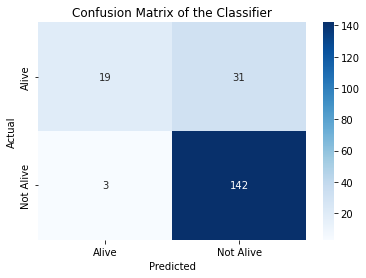

In [115]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = logreg_pred,
          labels = ['Alive', 'Not Alive'])

<strong>AUC Calculation</strong>

In [116]:
# area under the roc curve (auc)
print(roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4))


# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

0.6797


In [117]:
# zipping each feature name to its coefficient
#logreg_model_values = zip(got_dataset[candidate_dict['logit_sig']].columns,
                          #logreg_fit.coef_.ravel().round(decimals = 2))


# setting up a placeholder list to store model features
#logreg_model_lst = [('intercept', logreg_fit.intercept_[0].round(decimals = 2))]


# printing out each feature-coefficient pair one by one
#for val in logreg_model_values:
    #logreg_model_lst.append(val)
    

# checking the results
#for pair in logreg_model_lst:
    #print(pair)

# Classification Trees (CART Models)

In [118]:
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

In [119]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 0.779
Full Tree Testing ACCURACY : 0.8205
Full Tree AUC Score: 0.6762


In [120]:
# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


True Negatives : 19
False Positives: 31
False Negatives: 4
True Positives : 141



In [121]:
# INSTANTIATING a classification tree object
pruned_tree = DecisionTreeClassifier(max_depth = 4,
                                     min_samples_leaf = 25,
                                     random_state = 219)


# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(x_train, y_train)


# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', pruned_tree_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', pruned_tree_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4) # auc

Training ACCURACY: 0.7698
Testing  ACCURACY: 0.759
AUC Score        : 0.5562


In [122]:
# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 7
False Positives: 43
False Negatives: 4
True Positives : 141



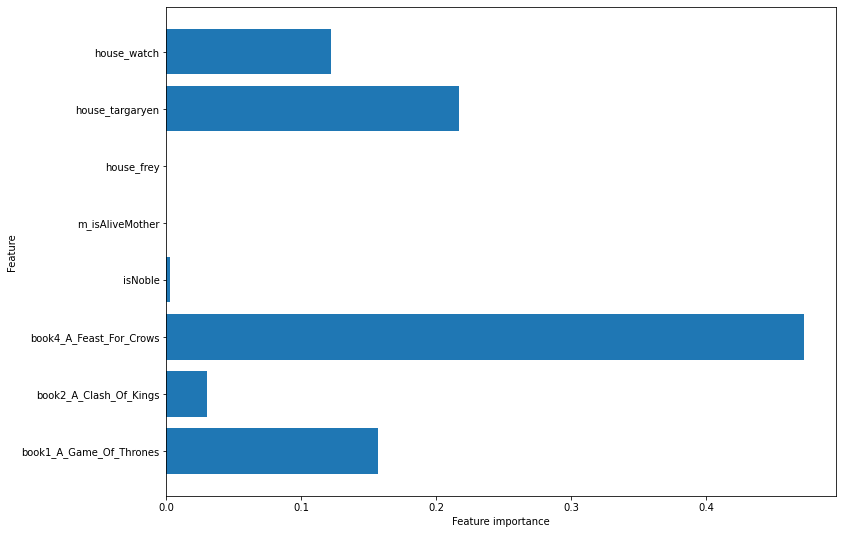

In [123]:
# plotting feature importance
plot_feature_importances(pruned_tree_fit,
                         train = x_train,
                         export = False)

In [124]:
# comparing results
print(f"""
Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      {logreg_auc_score}         {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Full Tree     {full_tree_auc_score}           {full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp}
Pruned Tree   {pruned_tree_auc_score}         {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
""")


# creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Logistic', 'Full Tree', 'Pruned Tree'],
           
    'AUC Score' : [logreg_auc_score, full_tree_auc_score, pruned_tree_auc_score],
    
    'Training Accuracy' : [logreg_train_score, full_tree_train_score,
                           pruned_tree_train_score],
           
    'Testing Accuracy'  : [logreg_test_score, full_tree_test_score,
                           pruned_tree_test_score],

    'Confusion Matrix'  : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp),
                           (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp)]}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)


Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      0.6797         (19, 31, 3, 142)
Full Tree     0.6762           (19, 31, 4, 141)
Pruned Tree   0.5562         (7, 43, 4, 141)



#   Classification Modeling with KNN¶

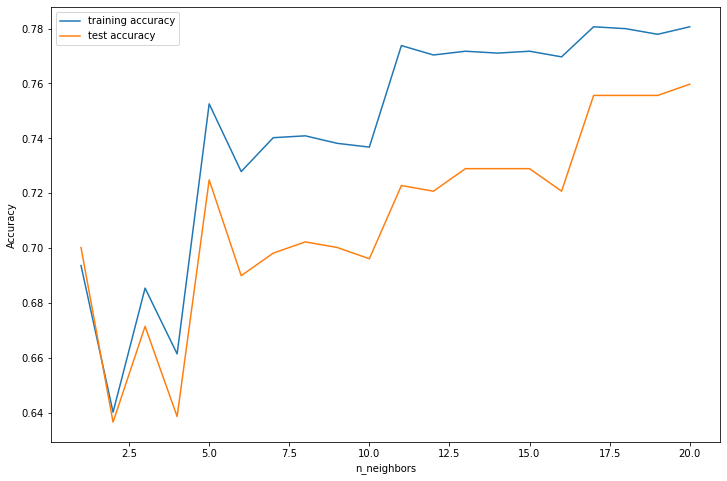

The optimal number of neighbors is: 20


In [125]:
# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(x_data        = got_data,
                                  y_data        = got_target,
                                  response_type = 'class')

In [126]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(got_data)


# TRANSFORMING the data
x_scaled     = scaler.transform(got_data)


# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 


# train-test split with the scaled data
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            x_scaled_df,
            got_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = got_target)


# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(x_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(x_test_scaled)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(x_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(x_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))


# saving scoring data
knn_train_score = knn_fit.score(x_train_scaled, y_train_scaled).round(4)
knn_test_score  = knn_fit.score(x_test_scaled, y_test_scaled).round(4)


# saving AUC score
knn_auc_score   = roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4)

Training ACCURACY: 0.7379
Testing  ACCURACY: 0.8051
AUC Score        : 0.7314


In [127]:
# unpacking the confusion matrix
knn_tree_tn, \
knn_tree_fp, \
knn_tree_fn, \
knn_tree_tp = confusion_matrix(y_true = y_test, y_pred = knn_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 7
False Positives: 43
False Negatives: 4
True Positives : 141



# Hyper Parameter Testing

In [128]:
# train/test split with the logit_sig variables
got_data   =  got_dataset.loc[ : , candidate_dict['logit_sig']]
got_target =  got_dataset.loc[ : , 'isAlive']


# train/test split
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = got_target) # preserving balance

<h4> Logistic Regression with Default Hyperparameters </h4>

In [129]:
# INSTANTIATING a logistic regression model with default values
lr_default = LogisticRegression(solver = 'lbfgs',
                                C = 1.0,
                                warm_start = False,
                                random_state = 219)

In [130]:
# FITTING the training data
lr_default_fit = lr_default.fit(x_train, y_train)


# PREDICTING based on the testing set
lr_default_pred = lr_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', lr_default_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', lr_default_fit.score(x_test, y_test).round(4))


# SCORING with AUC
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = lr_default_pred).round(4))


# saving scoring data for future use
logreg_train_score = lr_default_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = lr_default_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC score
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = lr_default_pred).round(4)

Training ACCURACY: 0.7693
Testing  ACCURACY: 0.8256
AUC Score        : 0.6797


# Hyperparameter Tuning with RandomizedSearchCV

In [131]:
# RandomizedSearchCV
########################################

# declaring a hyperparameter space
C_range          = np.arange(0.1, 5.0, 0.1)
warm_start_range = [True, False]
solver_range     = ['newton-cg', 'sag', 'lbfgs']


# creating a hyperparameter grid
param_grid = {'C'          : C_range,
              'warm_start' : warm_start_range,
              'solver'     : solver_range}


# INSTANTIATING the model object without hyperparameters
lr_tuned = LogisticRegression(random_state = 219,
                              max_iter     = 1000) # increased for convergence


# GridSearchCV object
lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
                                 param_distributions = param_grid, # parameters to tune
                                 cv                  = 3,          # how many folds in cross-validation
                                 n_iter              = 250,        # number of combinations of hyperparameters to try
                                 random_state        = 219,        # starting point for random sequence
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
lr_tuned_cv.fit(got_data, got_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", lr_tuned_cv.best_params_)
print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

Tuned Parameters  : {'warm_start': False, 'solver': 'sag', 'C': 1.4000000000000001}
Tuned CV AUC      : 0.593


In [132]:
#lr_tuned_cv.cv_results_

In [133]:
# checking the best estimator for the model
lr_tuned_cv.best_estimator_

LogisticRegression(C=1.4000000000000001, max_iter=1000, random_state=219,
                   solver='sag')

In [134]:
# building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
lr_tuned = LogisticRegression(C            = 3.9000000000000004,
                              warm_start   = True,
                              solver       = 'newton-cg',
                              max_iter     = 1000,
                              random_state = 219)


# FITTING the model to the full dataset
lr_tuned.fit(got_data, got_target) # this is ok because already tuned


# PREDICTING based on the testing set
lr_tuned_pred = lr_tuned.predict(x_test)


# SCORING the results
print('LR Tuned Training ACCURACY:', lr_tuned.score(x_train, y_train).round(4))
print('LR Tuned Testing  ACCURACY:', lr_tuned.score(x_test, y_test).round(4))
print('LR Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = lr_tuned_pred).round(4))


# saving scoring data for future use
lr_tuned_train_score = lr_tuned.score(x_train, y_train).round(4) # accuracy
lr_tuned_test_score  = lr_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
lr_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = lr_tuned_pred).round(4) # aucv

LR Tuned Training ACCURACY: 0.7687
LR Tuned Testing  ACCURACY: 0.8256
LR Tuned AUC Score        : 0.6862


# Hyperparameter Tuning on Classification Trees

In [135]:
# declaring a hyperparameter space
criterion_range = ['gini', 'entropy']
splitter_range  = ['best', 'random']
depth_range     = np.arange(1, 25, 1)
leaf_range      = np.arange(1, 100, 1)


# creating a hyperparameter grid
param_grid = {'criterion'        : criterion_range,
              'splitter'         : splitter_range,
              'max_depth'        : depth_range,
              'min_samples_leaf' : leaf_range}


# INSTANTIATING the model object without hyperparameters
tuned_tree = DecisionTreeClassifier(random_state = 219)


# RandomizedSearchCV object
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                   param_distributions   = param_grid,
                                   cv                    = 3,
                                   n_iter                = 1000,
                                   random_state          = 219,
                                   scoring = make_scorer(roc_auc_score,
                                             needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
tuned_tree_cv.fit(got_data, got_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

Tuned Parameters  : {'splitter': 'random', 'min_samples_leaf': 11, 'max_depth': 12, 'criterion': 'gini'}
Tuned Training AUC: 0.5833


In [136]:
# building a model based on hyperparameter tuning results

# INSTANTIATING a logistic regression model with tuned values
tree_tuned = DecisionTreeClassifier(splitter         = 'best',
                                    min_samples_leaf = 5,
                                    max_depth        = 8,
                                    criterion        = 'gini',
                                    random_state     = 219)


# FITTING to the FULL DATASET (due to cross-validation)
tree_tuned_fit = tree_tuned.fit(got_data, got_target)


# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(x_test)


# SCORING the results
print('Training ACCURACY:', tree_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_tuned_pred).round(4))


# saving scoring data for future use
tree_tuned_train_score = tree_tuned.score(x_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                       y_score = tree_tuned_pred).round(4) # auc

Training ACCURACY: 0.7767
Testing  ACCURACY: 0.8205
AUC Score        : 0.6762


In [137]:
# unpacking the confusion matrix
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")


True Negatives : 19
False Positives: 31
False Negatives: 4
True Positives : 141

